# CipherWords

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathlib import Path

In [155]:
import nltk

In [156]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [175]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/david/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [178]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/david/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [194]:
wnl = nltk.stem.WordNetLemmatizer()

In [199]:
import nltk.corpus

In [204]:
stopwords = nltk.corpus.stopwords.words('english')

Define the list of keywords to use:

In [288]:
K = [w.strip().lower() for w in open('../words.txt')]

A few keywords have spaces:

In [289]:
[k for k in K if ' ' in k]

['ice cream', 'loch ness', 'new york', 'scuba diver']

These could be implemented as a digram, which adds a lot of complexity for just a few words, or by removing the space, which requires a large enough training corpus to capture correlations with a less common form.  Instead, replace these words. We also replace a few words that have consistently obscure associations:

In [290]:
replacements = {
    # Compound words
    'ice cream': 'meringue',
    'loch ness': 'shetland',
    'new york': 'boston',
    'scuba diver': 'mariner',
    # Obscure associations
    'dice': 'roll', # dough, esta, hacer (spanish verbs)
    'leprechaun': 'jedi', # lovable, humpty, herriot (??)
    'straw': 'barley', #minister, secretary, condoleezza (Jack Straw was UK secretary of state)
    'undertaker': 'caregiver', # wrestling stuff
    'ray': 'lightsaber',
    'robin': 'condor',
    'angel': 'demon',
}
K = sorted([replacements.get(k, k) for k in K])

Load [word frequencies](https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists) for filtering out obscure words:

In [114]:
def load_freqs(filename='enwiki-20190320-words-frequency.txt'):
    freqs = {}
    wordpat = re.compile('^[a-z]+$')
    with open(filename) as f:
        for line in f:
            word, f = line.split()
            if not wordpat.match(word.lower()):
                continue
            freqs[word.lower()] = float(f)
    print(f'Loaded {len(freqs)} word frequencies from {filename}')
    return freqs

F1 = load_freqs()

Loaded 1507753 word frequencies from enwiki-20190320-words-frequency.txt


In [115]:
F2 = load_freqs('en_full.txt')

Loaded 1026874 word frequencies from en_full.txt


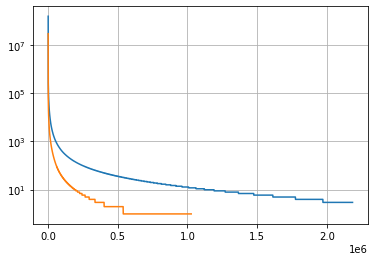

In [116]:
plt.plot(F.values());
plt.plot(F2.values());
plt.yscale('log');
plt.grid();

Download word embedding vectors from https://nlp.stanford.edu/projects/glove/

In [7]:
GLOVEDIR = Path('/Users/david/Data/Words/GLOVE')
assert GLOVEDIR.exists()

The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence.

In [130]:
class GloveBox:
    def __init__(self, filename, ndim):
        self.ndim = ndim
        self.filename = GLOVEDIR / filename
        assert self.filename.exists()
    def __enter__(self):
        self.f = open(self.filename)
        return self
    def __exit__(self, *args):
        self.f.close()
    class Line:
        def __init__(self, line, ndim):
            self.word, *self.values = line.split()
            if len(self.values) != ndim:
                raise ValueError(f'Badly formed line with {len(self.values)} values: "{line}"')
            self._vec = None
        @property
        def vec(self):
            if self._vec is None:
                self._vec = np.array([float(val) for val in self.values], np.float32)
            return self._vec
    def lines(self):
        for line in self.f:
            try:
                yield GloveBox.Line(line, self.ndim)
            except ValueError:
                pass

See below for how this list is constructed...

In [265]:
vetos = 'miguel,jose,luis,jah,roy,tom,ken,jenson,canadian,centre,changing,chinese,comedy,odi,dancing,died,pero,una,\
facing,filing,flew,flown,french,greek,uss,himalayan,eh,gyula,ii,suge,zat,living,thing,mexican,bic,los,piracy,racquet,\
andy,jan,kibo,roman,tael,shooting,shoot,sank,km,solana,wwe,teaching,theatre,tying,teeth,turkish,lesnar,orton,oroton,\
debby,whaling,dpp,metre,jimenez,maria,kmt,charlie,showalter,mckeon,sah,ohl,satyajit,robert,joschka,cabrera,chuck,\
shawshank,quasimodo,radin,floyd,gordy,jiabao,persie,nwa,clitoral,lech,iii,nagin,mining,sri,buffy,ruud,juan,hank,\
luh,gah,kah,rss'.split(',')

In [291]:
def load(threshold=10, minfreq=50, filename='glove.6B/glove.6B.{ndim}d.txt', keywords=K, freqs=F2, ndim=100):

    # First pass to load the vectors of all keywords.
    nkeys = len(keywords)
    keyvecs = np.empty((nkeys, ndim), np.float32)
    missing = list(keywords)
    filename = filename.format(ndim=ndim)
    with GloveBox(filename, ndim) as gb:
        for line in gb.lines():
            try:
                i = keywords.index(line.word)
                keyvecs[i] = line.vec
                missing.remove(line.word)
            except ValueError:
                continue
    if missing:
        print(f'Missing {len(missing)} keywords: {", ".join(missing)}.')
        return
    print(f'Located all {len(keywords)} keywords.')
    
    # Lemmatize all keywords.
    keylemmas = set([wnl.lemmatize(word) for word in keywords])
    
    # Keep track of clue lemmas.
    cluelemmas = []

    # Define a valid clue
    def valid_clue(clue):
        # Reject stop words.
        if clue in stopwords:
            return False
        # Reject words on our veto list.
        if clue in vetos:
            return False
        # Reject clues based on their part of speech
        pos = nltk.pos_tag([clue], tagset='universal')[0][1]
        if pos in ('ADP', 'CONJ', 'DET', 'PRT', 'PRON'):
            return False
        # Reject clues that are strictly containing or contained within any keyword
        for keyword in keywords:
            if (clue in keyword) or (keyword in clue):
                return False
        # Reject clues that have the same lemma as any keyword
        lemma = wnl.lemmatize(clue)
        if lemma in keylemmas:
            return False
        # Reject clues with the same lemma as a previous clue.
        if lemma in cluelemmas:
            return False
        # Remember this clue lemma.
        cluelemmas.append(lemma)
        return True

    # Second pass to measure keyword similarity of all possible clues.
    wordpat = re.compile('^[a-z]+$')
    cluewords, cluevecs = [], []
    with GloveBox(filename, ndim) as gb:
        for i, line in enumerate(gb.lines()):
            if line.word not in freqs or freqs[line.word] < minfreq:
                continue
            if not wordpat.match(line.word):
                continue
            # Calculate the log(prob) of this word co-ocurring with each keyword.
            logprobs = keyvecs.dot(line.vec)
            # Cut on the largest log(prob)
            if logprobs.max() < threshold:
                continue
            # Check that this clue is valid for all keywords.
            # We could relax this since a clue only needs to be valid for the keywords visible in a game
            # but that would add complexity in the game client.
            if not valid_clue(line.word):
                continue
            cluewords.append(line.word)
            cluevecs.append(line.vec)
    cluevecs = np.vstack(cluevecs)
    print(f'Selected {len(cluewords)} clue words, clue vectors size is {cluevecs.nbytes / (1<<20):.1f}Mb.')
    return cluewords, cluevecs, keyvecs

%time C,CV,KV = load()

Located all 400 keywords.
Selected 20206 clue words, clue vectors size is 7.7Mb.
CPU times: user 1min 45s, sys: 1.23 s, total: 1min 46s
Wall time: 21.8 s


In [293]:
def save(cluewords, cluevecs, keywords, keyvecs, basename=''):
    for (name,words,vecs) in (('clue',cluewords,cluevecs), ('key', keywords, keyvecs)):
        with open(basename + name + 'words.txt', 'w') as out:
            print('\n'.join(words), file=out)
        with open(basename + name + 'vecs.data', 'wb') as out:
            vecs.tofile(out)
        #pavecs = pa.Tensor.from_numpy(vecs)
        #with pa.OSFile(basename + name + 'vecs.arrow', 'wb') as sink:
        #    pa.ipc.write_tensor(pavecs, sink)

save(C, CV, K, KV)

In [93]:
def get_keyword_index(keyword, K):
    try:
        return K.index(keyword.lower())
    except ValueError:
        raise ValueError(f'{keyword} is not a keyword.')

In [94]:
def invalid_clue(clue, keywords):
    for keyword in keywords:
        if (clue in keyword) or (keyword in clue):
            return True
    return False

In [103]:
def vecsim(V1, V2):
    # Calculate the N1 x N2 matrix of similarities between vectors V1 with shape (N1,D) and V2 with shape (N2,D).
    return np.dot(V1, V2.T)
    #dot /= np.sqrt(np.dot(V1, V1.T) * np.dot(V2, V2.T))

In [295]:
def get_clues(groups, C, K, CV, KV, nbest=3, weights=[1, -1, -1, -1]):
    
    tags = ('selected', 'neutral', 'avoid', 'assasin')
    ngroups = len(tags)
    if len(groups) != ngroups:
        raise ValueError(f'Expected {len(tags)} groups.')
    
    # Find indexes of each keyword
    groups = [[get_keyword_index(keyword, K) for keyword in group] for group in groups]
    
    # Check for non-overlapping groups.
    all_groups = set()
    for i1, group1 in enumerate(groups):
        set1 = set(group1)
        if len(set1) != len(group1):
            raise ValueError(f'"{tags[i1]}" group has duplicate keyword.')
        all_groups |= set1
        for i2, group2 in enumerate(groups[i1+1:]):
            set2 = set(group2)
            if set1 & set2:
                raise ValueError(f'"{tags[i1]}" and "{tags[i1+i2+1]}" groups overlap.')
    all_groups = [K[i] for i in all_groups]

    similarity = np.zeros((ngroups, len(C)))

    # Calculate the joint similarity of the "selected" group for all possible clues.
    similarity[0] = vecsim(CV, KV[groups[0]]).sum(axis=1)

    # Calculate the maximum similarity to any single word in the other groups.
    for i in range(1, ngroups):
        similarity[i] = np.max(vecsim(CV, KV[groups[i]]), axis=1, initial=0)
    
    # Calculate the overall weighted score for all possible clues.
    score = np.dot(weights, similarity)
    
    # Find the clues with the highest score.
    order = np.argsort(score)[::-1]    
    best = []
    for i in order[:nbest]:
        best.append((C[i], score[i]))
    return best

get_clues((K[2:3], (), K[10:20], ()), C, K, CV, KV)

[('artillery', 14.416401863098145),
 ('reconnaissance', 13.789243698120117),
 ('expeditionary', 13.559124946594238)]

Manually scan the top-3 matches for each keyword to build a list of clues to veto (above), e.g. "centre" for "center".

In [296]:
def scan():
    for i in range(len(K)):
        rest = list(K)
        rest.remove(K[i])
        groups = (K[i:i+1], (), (), ())
        clues = [f'{clue[0]:18s}' for clue in get_clues(groups, C, K, CV, KV)]
        print(f'{K[i].upper():11s} : {" ".join(clues)}')

scan()

AFRICA      : south              asia               nations           
AGENT       : fbi                manager            cia               
AIR         : military           squadron           artillery         
ALIEN       : extraterrestrial   creatures          evil              
ALPS        : pyrenees           slopes             ski               
AMAZON      : itunes             ebay               microsoft         
AMBULANCE   : paramedics         bus                wounded           
AMERICA     : world              united             asia              
ANTARCTICA  : glacier            expedition         mapped            
APPLE       : microsoft          intel              iphone            
ARM         : shoulder           leg                right             
ATLANTIS    : shuttle            astronauts         endeavour         
AUSTRALIA   : zealand            britain            wales             
AZTEC       : inca               mayan              vedic             
BACK  